This code is used to reformat the data quoted from various papers, 
then compare the pulsar positions from timing and Gaia astrometry.

In [34]:
from functools import reduce

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

from astropy.table import Table, join
from astropy import units as u

import seaborn as sns

from psrcrf_tools import *

# %config InlineBackend.figure_format = "svg"

# 1. Data preparation

Read the timing solution data.

In [2]:
timing_table = Table.read("../data/timing_edr3.fits",)
timing_table.sort("psr_name")

Add unit information

In [3]:
timing_table["plx"].unit = u.mas
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [4]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")

# edr3_antf_table.show_in_notebook()

Only keep the astrometric parameters from Gaia.

In [5]:
edr3_antf_table = edr3_antf_table['name', 'source_id', 'parallax',
                                  'parallax_error', ]

edr3_antf_table.rename_columns([
    "name",
    "parallax",
    "parallax_error",
], ["psr_name", "plx", "plx_err"])

Add unit information

In [6]:
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["plx_err"].unit = u.mas

Supplement the timing table with the Gaia astrometrical information.

In [7]:
edr3_timing = join(timing_table,
                   edr3_antf_table,
                   keys="psr_name",
                   join_type="left",
                   table_names=["t", "g"])

# Remove pulsars that do not have proper motion information in Gaia EDR3
mask = (edr3_timing["plx_g"] < 1e10)
edr3_timing = edr3_timing[mask]

In [8]:
edr3_timing_pm = edr3_timing[(edr3_timing["plx_err_t"] != 0)]
count_psr_nb(edr3_timing_pm)

There are 4 pulsars with 20 measurements.


In [9]:
edr3_timing_pm["psr_name", "plx_t", "plx_g", "ref", "eph"]

psr_name,plx_t,plx_g,ref,eph
,mas,mas,,
bytes12,float64,float64,bytes6,bytes5
J0437-4715,6.373,7.1008,rhc+16,DE421
J0437-4715,6.441,7.1008,vlh+16,DE421
J0437-4715,1.0,7.1008,bbm+97,DE200
J0437-4715,6.418,7.1008,pdd+19,DE436
J1012+5307,1.3,1.7448,abb+18,DE436
J1012+5307,0.782,1.7448,vlh+16,DE421
J1012+5307,0.933,1.7448,pdd+19,DE436
J1012+5307,1.22,1.7448,lwj+09,DE405


## DE200 vs. Gaia EDR3

In [10]:
mask = edr3_timing_pm["eph"] == "DE200"
pm_tab200 = edr3_timing_pm[mask]

pm_tab200

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra,pmdec,plx_t,ra_err,dec_err,pmra_err,pmdec_err,plx_err_t,ref,comment,source_id,plx_g,plx_err_g
,,d,,,,,,mas,,,,,mas,,,,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64
J0437-4715,J0437-4715,49615.0,DE200,69.31556254166667,-47.25226463888889,121.3,-70.4,1.0,0.20363151618244418,0.2,0.2,0.30000000000000004,5.0,bbm+97,,4789864076732331648,7.1008,0.5245


## DE405 vs. Gaia EDR3

In [11]:
mask = edr3_timing_pm["eph"] == "DE405"
pm_tab405 = edr3_timing_pm[mask]

pm_tab405

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra,pmdec,plx_t,ra_err,dec_err,pmra_err,pmdec_err,plx_err_t,ref,comment,source_id,plx_g,plx_err_g
,,d,,,,,,mas,,,,,mas,,,,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64
J1012+5307,J1012+5307,50700.0,DE405,153.13930875416665,53.117389083333336,2.562,-25.61,1.22,0.08912635815241264,0.13,0.014,0.02,0.26,lwj+09,,851610861391010944,1.7448,0.2906


## DE421 vs. Gaia EDR3

In [12]:
mask = edr3_timing_pm["eph"] == "DE421"
pm_tab421 = edr3_timing_pm[mask]

pm_tab421

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra,pmdec,plx_t,ra_err,dec_err,pmra_err,pmdec_err,plx_err_t,ref,comment,source_id,plx_g,plx_err_g
,,d,,,,,,mas,,,,,mas,,,,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64
J0437-4715,J0437-4715,54500.0,DE421,69.3162340571,-47.2525307528,121.439,-71.475,6.373,0.00602974,0.00626552,0.001915,0.001954,0.086288,rhc+16,PPTA-DR1e,4789864076732331648,7.1008,0.5245
J0437-4715,J0437-4715,54500.0,DE421,69.3162340617,-47.2525307528,121.441,-71.475,6.441,0.00373391,0.00383898,0.001714,0.001865,0.074791,vlh+16,IPTA-DR1,4789864076732331648,7.1008,0.5245
J1012+5307,J1012+5307,55000.0,DE421,153.1393230512,53.1173055972,2.627,-25.458,0.782,0.05085026,0.06366704,0.010222,0.013951,0.193807,vlh+16,IPTA-DR1,851610861391010944,1.7448,0.2906
J1012+5307,J1012+5307,54902.0,DE421,153.1393227083333,53.117307527777776,2.5,-25.6,1.0,0.5401607710644697,0.7000000000000001,0.2,0.2,3.0,mnf+16,NANOGrav-9yr,851610861391010944,1.7448,0.2906
J1012+5307,J1012+5307,55000.0,DE421,153.13932300416664,53.11730555277778,2.609,-25.482,0.71,0.0450133996565745,0.060000000000000005,0.008,0.011,0.17,dcl+16,EPTA,851610861391010944,1.7448,0.2906
J1024-0719,J1024-0719,54500.0,DE421,156.1611609737,-7.3220466056,-35.331,-48.318,0.526,0.09145182,0.18954466,0.039686,0.079472,0.228211,rhc+16,PPTA-DR1e,3775277872387310208,0.8572,0.2782
J1024-0719,J1024-0719,55000.0,DE421,156.16114740833333,-7.322064986111111,-35.28,-48.18,0.8,0.07438840767090601,0.15,0.03,0.07,0.17,dcl+16,EPTA,3775277872387310208,0.8572,0.2782
J1024-0719,J1024-0719,55800.0,DE421,156.1611257875,-7.322094333333333,-35.2,-48.0,0.6,0.133899124994967,0.30000000000000004,0.1,0.2,0.30000000000000004,mnf+16,NANOGrav-9yr,3775277872387310208,0.8572,0.2782


## DE430 vs. Gaia EDR3

In [13]:
mask = edr3_timing_pm["eph"] == "DE430"
pm_tab430 = edr3_timing_pm[mask]

pm_tab430

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra,pmdec,plx_t,ra_err,dec_err,pmra_err,pmdec_err,plx_err_t,ref,comment,source_id,plx_g,plx_err_g
,,d,,,,,,mas,,,,,mas,,,,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64


## DE436 vs. Gaia EDR3

In [14]:
mask = edr3_timing_pm["eph"] == "DE436"
pm_tab436 = edr3_timing_pm[mask]

pm_tab436

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra,pmdec,plx_t,ra_err,dec_err,pmra_err,pmdec_err,plx_err_t,ref,comment,source_id,plx_g,plx_err_g
,,d,,,,,,mas,,,,,mas,,,,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64
J0437-4715,J0437-4715,55000.0,DE436,69.3163022208,-47.2525579444,121.443,-71.474,6.418,0.00503983,0.00530447,0.001435,0.00156,0.067263,pdd+19,IPTA-DR2,4789864076732331648,7.1008,0.5245
J1012+5307,J1012+5307,55291.0,DE436,153.139324,53.11730002777778,2.66,-25.5,1.3,0.09002681088274288,0.1,0.03,0.04,0.4,abb+18,NANOGrav-11yr,851610861391010944,1.7448,0.2906
J1012+5307,J1012+5307,55000.0,DE436,153.1393230429,53.1173056083,2.614,-25.486,0.933,0.04953387,0.06394984,0.010224,0.013773,0.192303,pdd+19,IPTA-DR2,851610861391010944,1.7448,0.2906
J1024-0719,J1024-0719,55636.0,DE436,156.1611309125,-7.322087388888889,-35.27,-48.22,0.83,0.059510723146806305,0.1,0.017,0.03,0.13,rsc+21,PPTA-DR2e,3775277872387310208,0.8572,0.2782
J1024-0719,J1024-0719,56239.0,DE436,156.16111399166664,-7.3221103888888885,-35.29,-48.2,0.8,0.08926608011575785,0.2,0.06,0.1,0.2,abb+18,NANOGrav-11yr,3775277872387310208,0.8572,0.2782
J1024-0719,J1024-0719,55000.0,DE436,156.1611475046,-7.3220649306,-35.267,-48.225,0.822,0.04801056,0.09847672,0.017593,0.036161,0.102243,pdd+19,IPTA-DR2,3775277872387310208,0.8572,0.2782
B1953+29,J1955+2908,56568.0,DE436,298.86614760000003,29.145400416666668,-1.1,-4.2,0.0,0.11790718871207326,0.2,0.1,0.2,1.0,abb+18,NANOGrav-11yr,2028584968839606784,0.4749,0.1695
B1953+29,J1955+2908,55000.0,DE436,298.8661490629,29.1454053639,-1.029,-4.171,-1.178,0.17596624,0.24031268,0.055342,0.078402,1.098837,pdd+19,IPTA-DR2,2028584968839606784,0.4749,0.1695


# 2 Direct comparison

## 2.1 Stastically significant offset

In [15]:
dplx = edr3_timing_pm["plx_t"] - edr3_timing_pm["plx_g"]
dplx_err = np.sqrt(edr3_timing_pm["plx_err_g"]**2 +
                   edr3_timing_pm["plx_err_t"]**2)

X_plx = dplx / dplx_err

<Figure size 432x288 with 0 Axes>

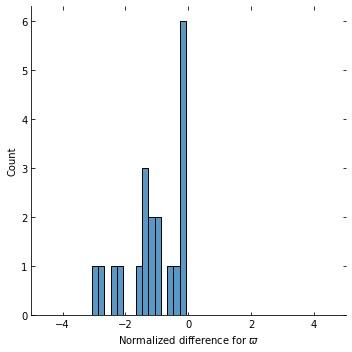

In [16]:
plt.clf()
sns.displot(
    X_plx,
    binwidth=0.2, height=5, facet_kws=dict(margin_titles=True),
)
plt.xlim([-5, 5])
plt.xlabel("Normalized difference for $\\varpi$")
plt.tight_layout()

In [17]:
print("N      PLX")
print("sigma  %")
for i in range(1, 11):
    per_plx = count_sigma(X_plx, i)

    print("{:2d}     {:2.0f} ".format(i, per_plx))

N      PLX
sigma  %
 1     50 
 2     80 
 3     95 
 4     100 
 5     100 
 6     100 
 7     100 
 8     100 
 9     100 
10     100 


In [18]:
print("X_plx >= 3")

mask = np.fabs(X_plx) >= 3
edr3_timing_pm[mask]["psr_name", "eph", "plx_t",
                     "plx_err_t", "plx_g", "plx_err_g", "ref"]

X_plx >= 3


psr_name,eph,plx_t,plx_err_t,plx_g,plx_err_g,ref
,,mas,mas,mas,mas,
bytes12,bytes5,float64,float64,float64,float64,bytes6
J1012+5307,DE421,0.71,0.17,1.7448,0.2906,dcl+16


## 2.1 Gaia (y) vs. Timing (x)

A ordinary linear regression of y = k * x + b.

First, I use all pulsars.

In [19]:
results = fit_plx_offset(edr3_timing_pm["plx_t"], edr3_timing_pm["plx_g"],
                         dplx_err)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.940
Model:                            WLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     282.6
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.88e-12
Time:                        12:35:00   Log-Likelihood:                -18.272
No. Observations:                  20   AIC:                             40.54
Df Residuals:                      18   BIC:                             42.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3610      0.131      2.749      0.013       0.085       0.637
x1             1.0330      0.061     16.812      0.000       0.904       1.162
==============================================================================
Omnibus:                        1.158   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.560   Jarque-Bera (JB):                0.899
Skew:                           0.235   Prob(JB):                        0.638
Kurtosis:                       2.074   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Then I try to remove points with minus timing parallax.

In [20]:
mask = edr3_timing_pm["plx_t"] > 0
results = fit_plx_offset(edr3_timing_pm[mask]["plx_t"],
                         edr3_timing_pm[mask]["plx_g"], dplx_err[mask])
results.summary()

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.957
Model:                            WLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     333.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.18e-11
Time:                        12:35:00   Log-Likelihood:                -11.587
No. Observations:                  17   AIC:                             27.17
Df Residuals:                      15   BIC:                             28.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3025      0.125      2.425      0.028       0.037       0.568
x1             1.0611      0.058     18.254      0.000       0.937       1.185
==============================================================================
Omnibus:                        1.412   Durbin-Watson:                   1.097
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.182
Skew:                           0.564   Prob(JB):                        0.554
Kurtosis:                       2.372   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

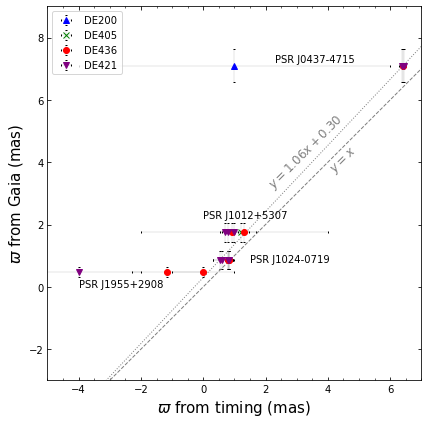

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(pm_tab200["plx_t"],
            pm_tab200["plx_g"],
            xerr=pm_tab200["plx_err_t"],
            yerr=pm_tab200["plx_err_g"],
            fmt="b^",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE200")

ax.errorbar(pm_tab405["plx_t"],
            pm_tab405["plx_g"],
            xerr=pm_tab405["plx_err_t"],
            yerr=pm_tab405["plx_err_g"],
            fmt="gx",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE405")

ax.errorbar(pm_tab436["plx_t"],
            pm_tab436["plx_g"],
            xerr=pm_tab436["plx_err_t"],
            yerr=pm_tab436["plx_err_g"],
            fmt="ro",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE436")

ax.errorbar(pm_tab421["plx_t"],
            pm_tab421["plx_g"],
            xerr=pm_tab421["plx_err_t"],
            yerr=pm_tab421["plx_err_g"],
            fmt="v",
            color="purple",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE421")


x = np.arange(-5, 10, 0.1)
ax.plot(x, x, "--", color="tab:grey", lw=1)
ax.text(4, 3.7, "$y=x$", rotation=45, color="tab:grey", fontsize=12)

ax.plot(x, 1.06 * x + 0.30, ls="dotted", lw=1, color="tab:grey")
ax.text(2, 3.2, "$y=1.06x+0.30$", rotation=45, color="tab:grey", fontsize=12)

ax.text(2.3, 7.2, "PSR J0437-4715", color="k")
ax.text(0., 2.2, "PSR J1012+5307", color="k")
ax.text(1.5, 0.8, "PSR J1024-0719", color="k")
ax.text(-4, 0., "PSR J1955+2908", color="k")

ax.axis("square")
ax.axis([-5, 7, -3, 9])
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

ax.set_xlabel("$\\varpi$ from timing (mas)", fontsize=15)
ax.set_ylabel("$\\varpi$ from Gaia (mas)", fontsize=15)


# plt.grid(lw=1)
plt.tight_layout()
plt.legend(loc="upper left")

# plt.savefig("../plots/gedr3_plx-com.eps")

## 2.2 Gaia (x) vs. Timing (y)

A ordinary linear regression of y = k * x + b.

First, I use all pulsars.

In [22]:
results = fit_plx_offset(edr3_timing_pm["plx_g"], edr3_timing_pm["plx_t"],
                         dplx_err)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.940
Model:                            WLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     282.6
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.88e-12
Time:                        12:35:00   Log-Likelihood:                -17.004
No. Observations:                  20   AIC:                             38.01
Df Residuals:                      18   BIC:                             40.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2494      0.135     -1.853      0.080      -0.532       0.033
x1             0.9101      0.054     16.812      0.000       0.796       1.024
==============================================================================
Omnibus:                        2.229   Durbin-Watson:                   1.155
Prob(Omnibus):                  0.328   Jarque-Bera (JB):                1.674
Skew:                          -0.542   Prob(JB):                        0.433
Kurtosis:                       2.087   Cond. No.                         3.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Then I try to remove points with minus timing parallax.

In [23]:
mask = edr3_timing_pm["plx_t"] > 0
results = fit_plx_offset(edr3_timing_pm[mask]["plx_g"], edr3_timing_pm[mask]["plx_t"],
                         dplx_err[mask])
results.summary()

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.957
Model:                            WLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     333.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.18e-11
Time:                        12:35:00   Log-Likelihood:                -10.205
No. Observations:                  17   AIC:                             24.41
Df Residuals:                      15   BIC:                             26.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2140      0.124     -1.727      0.105      -0.478       0.050
x1             0.9018      0.049     18.254      0.000       0.797       1.007
==============================================================================
Omnibus:                        2.618   Durbin-Watson:                   1.276
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.026
Skew:                          -0.800   Prob(JB):                        0.363
Kurtosis:                       2.455   Cond. No.                         3.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


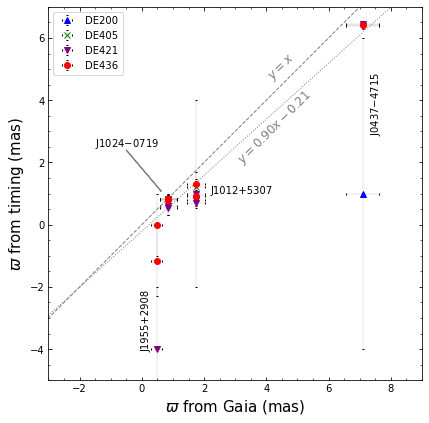

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(pm_tab200["plx_g"], pm_tab200["plx_t"],

            yerr=pm_tab200["plx_err_t"],
            xerr=pm_tab200["plx_err_g"],
            fmt="b^",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE200")

ax.errorbar(pm_tab405["plx_g"], pm_tab405["plx_t"],

            yerr=pm_tab405["plx_err_t"],
            xerr=pm_tab405["plx_err_g"],
            fmt="gx",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE405")

ax.errorbar(pm_tab421["plx_g"], pm_tab421["plx_t"],

            yerr=pm_tab421["plx_err_t"],
            xerr=pm_tab421["plx_err_g"],
            fmt="v",
            color="purple",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE421")

ax.errorbar(pm_tab436["plx_g"], pm_tab436["plx_t"],

            yerr=pm_tab436["plx_err_t"],
            xerr=pm_tab436["plx_err_g"],
            fmt="ro",
            ecolor="k",
            elinewidth=0.1,
            capsize=1,
            label="DE436")


x = np.arange(-5, 10, 0.1)
ax.plot(x, x, "--", color="tab:grey", lw=1)
ax.text(4, 4.7, "$y=x$", rotation=45, color="tab:grey", fontsize=12)

ax.plot(x, 0.90 * x - 0.21, ls="dotted", lw=1, color="tab:grey")
ax.text(3, 2., "$y=0.90x-0.21$", rotation=45, color="tab:grey", fontsize=12)

ax.text(7.3, 3., "J0437$-$4715", color="k", rotation=90)
ax.text(2.2, 1.0, "J1012+5307", color="k")
ax.text(-1.5, 2.5, "J1024$-$0719", color="k")
ax.arrow(-0.5, 2.4, 1.1, -1.3, width=0.01, color="tab:grey")
ax.text(0., -4, "J1955+2908", color="k", rotation=90)

ax.axis("square")
ax.axis([-3, 9, -5, 7])
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set_ylabel("$\\varpi$ from timing (mas)", fontsize=15)
ax.set_xlabel("$\\varpi$ from Gaia (mas)", fontsize=15)
# ax.arrow(-4.5, -2.5, 0, 1, width=0.05, color="tab:grey")

# plt.grid(lw=1)
plt.tight_layout()
plt.legend(loc="upper left")

plt.savefig("../plots/gedr3_plx-com.eps")


In [25]:
edr3_timing_pm["psr_name", "plx_t", "plx_g", "ref", "eph"]

psr_name,plx_t,plx_g,ref,eph
,mas,mas,,
bytes12,float64,float64,bytes6,bytes5
J0437-4715,6.373,7.1008,rhc+16,DE421
J0437-4715,6.441,7.1008,vlh+16,DE421
J0437-4715,1.0,7.1008,bbm+97,DE200
J0437-4715,6.418,7.1008,pdd+19,DE436
J1012+5307,1.3,1.7448,abb+18,DE436
J1012+5307,0.782,1.7448,vlh+16,DE421
J1012+5307,0.933,1.7448,pdd+19,DE436
J1012+5307,1.22,1.7448,lwj+09,DE405
